## Diving into Feature Engineering:
In this notebook I'll use the /feature_columns/ method from tensorflow. More specific, the following features:
 + Bucketized columns
 + Crossed columns
 + Embedding

Designing the correct features and rating the importance of every input is an important step in the design of a machine learning model. With these tools the training process gets faster executing times (if we are able to drop some inputs in exchange for crossed features with much more significance than other inputs), and better performance overall (lower variance). However, some features could induce the model to overfit the data, specially when the dataset is not long enough. 

In [1]:
# import important stuff:
import tensorflow as tf
import pandas as pd
from tensorflow import feature_column as fc
import seaborn as sea
from sklearn.model_selection import train_test_split

import os


# downloading the data
!gsutil cp gs://cloud-training/mlongcp/v3.0_MLonGC/toy_data/housing_pre-proc_toy.csv /data
# This dataset (provided by google) already has been cleaned and wrangled.


df = pd.read_csv("data/housing_pre-proc_toy.csv")
df.head()

Copying gs://cloud-training/mlongcp/v3.0_MLonGC/toy_data/housing_pre-proc_toy.csv...
/ [0 files][    0.0 B/138.8 KiB]                                                
OSError: Acceso denegado.


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41,880,129,322,126,8.3252,452600,NEAR BAY
1,-122.22,37.86,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY
2,-122.24,37.85,52,1467,190,496,177,7.2574,352100,NEAR BAY
3,-122.25,37.85,52,1274,235,558,219,5.6431,341300,NEAR BAY
4,-122.25,37.85,52,1627,280,565,259,3.8462,342200,NEAR BAY


It's very important to explore the data, like get the distribution each column shows, creating relations between columns (later this will help when crossing some features), and identify which columns. It's time for some fancy plots.

In [2]:
# This method gives general info about each column:
df.describe()

# Some cols have higher std (standar deviation). This gives a basic idea of how the data is distributed, and (in certain manner) if its statisticly suficcient.


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,-121.501836,37.802288,30.088400,2522.734000,491.862400,1246.225200,458.122000,3.694312,170288.731200
std,1.015963,0.803090,13.878416,1988.411988,362.499497,925.075463,341.744308,1.859422,97550.278529
min,-124.300000,36.130000,2.000000,12.000000,4.000000,18.000000,2.000000,0.499900,22500.000000
25%,-122.200000,37.600000,18.000000,1420.750000,282.000000,718.000000,263.000000,2.357875,92950.000000
50%,-122.030000,37.800000,30.000000,2052.000000,402.000000,1030.500000,374.500000,3.262200,150800.000000
75%,-120.697500,37.960000,41.000000,3007.250000,581.250000,1488.250000,538.000000,4.662975,219650.000000
max,-118.910000,41.950000,52.000000,28258.000000,3864.000000,12203.000000,3701.000000,15.000100,500001.000000


In [3]:
# Set the theme:
sea.set_theme(palette="flare")

First lets see the distribution of the data from the **housing_median_age** column:

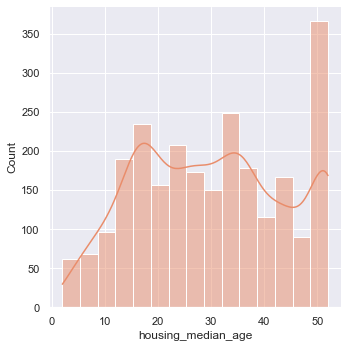

In [4]:
sea.displot(data = df, x = 'housing_median_age', kde = True)

It looks like a normal distribution with noticeable noise. There are buckets with more data than others. And more data on the last bucket in comparisson with the buckets close to the mean. This factors can cause overfitting, the model having bias over the ages that have more data in contrast with the less populated. 
Overall, we could say that (in most cases) a new house can be sold with a higher price than older houses. 

Next, some distributions with huge outliers:

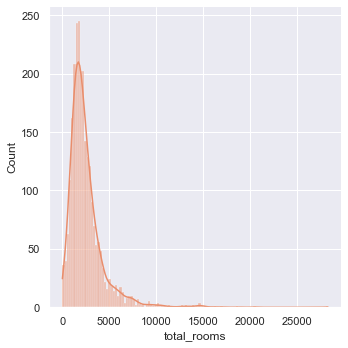

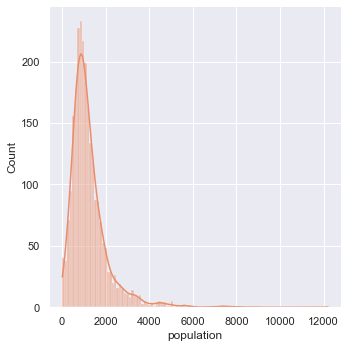

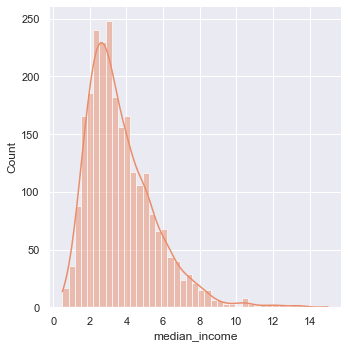

In [5]:
sea.displot(data = df, x = 'total_rooms', kde = True)
sea.displot(data = df, x = 'population', kde = True)
sea.displot(data = df, x = 'median_income', kde = True)

As noted by the quantiles in the **describe(  )** output, we can se that the max vaules of this columns are very high. Thus, the model, when computing the loss derivate, is very likely to overfit the data. Some kind of regularization should be implemented for training.

Now, the pandas' dataframe has to be converted to a tf.dataset to be used in training:

In [23]:
col_names = list(df.columns)
label_name = 'median_house_value'

# The numeric columns:
col_numerics = [
    'longitude', 'latitude', 'housing_median_age', 
    'total_rooms', 'total_bedrooms', 'population', 
    'households', 'median_income']

# There's only 1 categorical column:
col_string = 'ocean_proximity'

# Batch_size (to be used in the make_csv_dataset from tensorflow])
batch_size = 32

Now its time to create a tensorflow dataset (tf.data.Dataset) to be used in the training process. In this ocassion, the method used will be applying a function on every row (using the map function) to split the columns, thereby resulting in a pair of "inputs, label":

In [24]:
# This functions takes a row of the dataset (as a list) and split it into a (inputs, label) pair
def split_rows(row):
    label = row.pop(label_name)
    return row, label

# This function takes the name (or pattern) of the csv file were the data is.
# There are other methods to load a tensorflow dataset (like converting lists to tensors with tf.data.Dataset.from_tensor_slices())
# but with bigger datasets, its more convenient to use .make_csv_dataset() method because it can batch the dataset from the file and 
# prefetch batchs.

def trans_dataset(pattern, mode = 'eval', batch_size = 1):
    dataset = tf.data.experimental.make_csv_dataset(pattern, batch_size, col_names)
    # tf.data.Dataset.from_tensor_slices(df[col_numerics]) z-- another way
    dataset = dataset.map(split_rows)           # 'map' method applies the function to every row, is like 'apply'

    if mode == 'train':
        dataset.shuffle(1000).repeat()

    return dataset



In [31]:
# Given the small size of the dataset (2500 rows) we can use the 'df' dataframe previously loaded:
# and then use this datasets in the model training-validation-test. 
train_ds, test_ds = train_test_split(df, test_size = 0.2)
train_ds, val_ds = train_test_split(train_ds, test_size = 0.2)

# However, when the datasets are large enough, we can use the function trans_dataset():
train_ds.to_csv("data/train_ds.csv", index = False)
test_ds.to_csv("data/test_ds.csv", index = False)
val_ds.to_csv("data/val_ds.csv", index = False)

train_ds = trans_dataset('data/train*', 'train', batch_size)
val_ds = trans_dataset('data/val*', batch_size=1)

         longitude     latitude  housing_median_age   total_rooms  \
count  1600.000000  1600.000000         1600.000000   1600.000000   
mean   -121.510994    37.797300           30.323125   2511.988750   
std       1.003628     0.782231           14.069513   2082.873946   
min    -124.210000    36.130000            2.000000     12.000000   
25%    -122.210000    37.600000           18.000000   1374.750000   
50%    -122.030000    37.800000           30.000000   2020.500000   
75%    -120.767500    37.960000           42.000000   2928.250000   
max    -118.910000    41.950000           52.000000  28258.000000   

       total_bedrooms    population   households  median_income  \
count     1600.000000   1600.000000  1600.000000    1600.000000   
mean       487.170000   1243.975625   453.686250       3.668786   
std        367.728999    957.002433   346.681187       1.876051   
min          4.000000     18.000000     5.000000       0.499900   
25%        276.750000    702.750000   260.0

**Models**: 
Two NN models will be tested. The first one will be a baseline model, with no change on the inputs (they'll go entirely as features). The second one will integrate more features and it'll showcase corss, buckets and other types of features. 

_Here goes nothing (model 1 ,no-Features)_

In [35]:
# ALl numeric inputs will be normalized, this is the only modification to the inputs in this baseline model.
def get_scaler(data):
    def mixmax(x):
        mini = train_ds[data].min()
        maxi = train_ds[data].max()
        return (x - mini) / (maxi - mini)
        return mixmax


feature_cols = []

for feature in col_numerics:
    scaler = get_scaler(feature)
    feature_cols.append(fc.numeric_column(feature, normalizer_fn=scaler))

[NumericColumn(key='longitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='latitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='housing_median_age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='total_rooms', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='total_bedrooms', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='population', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='households', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='median_income', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]


In [36]:
from tensorflow.keras import layers

# Dense tensor as inputj
features_tensor = tf.keras.layers.DenseFeatures(feature_cols, dtype = 'float64')
nn = len(feature_cols)
print("Input dim: {}".format(str(nn)))

for features, label in train_ds.take(1):
  print(features, label)

basel_model = tf.keras.Sequential([
    features_tensor,
    tf.keras.layers.Dense(12, input_dim = nn, activation = 'relu'),
    tf.keras.layers.Dense(8, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'linear', name = 'median_house_value')
])

basel_model.compile(optimizer = 'adam',
                    loss = 'mse',
                    metrics = ['mse'])

basel_model.fit(train_ds, validation_data = val_ds, epochs = 32)

Input dim: 8
OrderedDict([('longitude', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([-119.46, -121.93, -122.36, -122.29, -120.34, -122.27, -119.94,
       -122.22, -122.2 , -122.23, -122.28, -122.33, -122.28, -121.84,
       -122.25, -122.14, -122.17, -119.76, -122.17, -121.61, -122.21,
       -121.93, -122.17, -122.18, -122.1 , -122.04, -122.31, -119.89,
       -121.79, -122.  , -119.56, -122.22], dtype=float32)>), ('latitude', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([36.6 , 37.93, 37.95, 37.81, 38.23, 37.82, 38.95, 37.79, 37.78,
       37.79, 37.84, 37.97, 37.86, 37.99, 37.85, 37.71, 37.78, 36.73,
       37.77, 37.86, 37.81, 37.78, 37.78, 37.75, 37.66, 37.97, 37.94,
       36.64, 38.01, 37.98, 36.71, 37.79], dtype=float32)>), ('housing_median_age', <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([18, 16, 38, 46, 10, 40, 25, 38, 39, 40, 52, 19, 49, 13, 52, 18, 49,
       46, 30, 30, 52,  2, 42, 45, 33, 10, 38, 34, 17, 36, 29, 52])>), ('total_rooms', <tf.Tensor

KeyboardInterrupt: 